In [43]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [44]:
water_data = pd.read_csv('water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [45]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.
Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna()

In [46]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

Убедимся в отсутствии пропусков:

In [47]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [48]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [49]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, 2620 образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 656 являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (X_train, y_train) и рассчитать метрики на валидационной выборке (X_valid, y_valid).

В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

# Метод Hold-Out

In [51]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [52]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [53]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


# Метод k-fold

In [54]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [55]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [56]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.03599977, 0.03799915, 0.03500271, 0.03300428, 0.02900124]),
 'score_time': array([0.00200081, 0.00200009, 0.00200057, 0.00300097, 0.00300431]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [57]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

# Метод LeaveOneOut

In [58]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


0    0.60989
1    0.39011
Name: Potability, dtype: float64

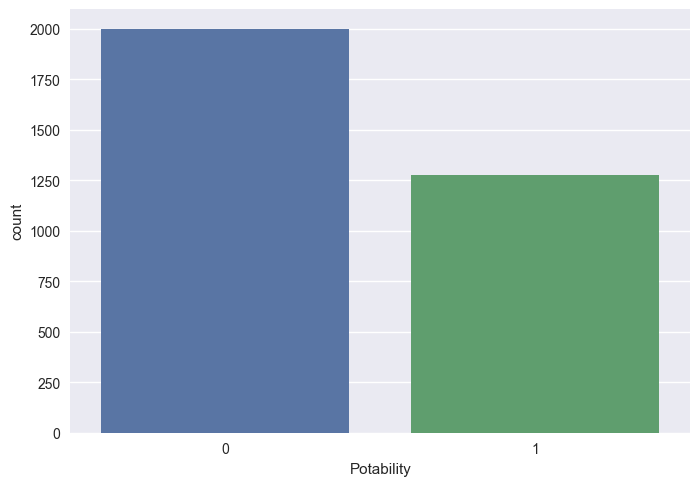

In [59]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

# СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ
Давайте на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения hold-out, которое мы проводим с помощью функции train_test_split(). Для начала проведём обычное случайное разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

In [60]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


Мы видим, что соотношения классов в тренировочной выборке — 62/38, а в тестовой — 57/43. Давайте попробуем сбалансировать соотношения.

Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [61]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


Теперь в каждом из наборов данных одинаковые соотношения классов — 61/39. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.

А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [62]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — 61/39.

Так же, как и другие кросс-валидаторы, объект класса StratifiedKFold может быть использован в функции cross_validate().

# Метрики при дисбалансе
Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [63]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

Precision для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
Recall для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.
-мера — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.
Однако мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

# Взвешивание объектов

In [64]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Так гораздо лучше! Обратите внимание на метрики класса 1: значение  поднялось с 0.65 до 0.69. Это произошло потому, что мы стали чаще находить образцы пригодной для питья воды, за счёт чего recall увеличился с 0.55 до 0.76 (правда, немного упал precision).

Да, метрики для класса 0 стали ниже, и у нас слегка упала метрика accuracy, но таков закон баланса — «чтобы где-то прибыло, надо, чтобы где-то убыло». Пусть в целом картина всё ещё не идеальна, но она заметно улучшилась. Разница метрик между классами значительно сократилась. 

# Выбор порога вероятности. PR -кривая
Подберём порог вероятности с помощью PR-кривой для нашего примера. Так как порог вероятности является внешним параметром модели, будет правильнее подбирать его на кросс-валидации, организованной на тренировочном наборе данных, а итоговое качество оценивать на отложенной выборке.

Пусть мы хотим найти такой порог вероятности, при котором наблюдается максимум метрики F1 для класса 1 (питьевая вода).

Перед построением PR-кривой нам необходимо предсказать вероятность принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [65]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [66]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [67]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума F1 -score.

Best threshold = 0.33, F1-Score = 0.69


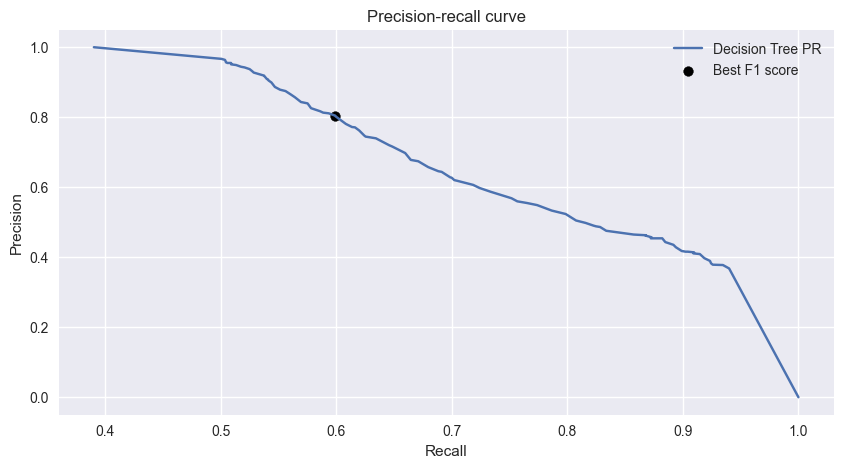

In [68]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум  (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [72]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
theresold_opt=0.33
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > theresold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Итак, при применении метода подбора вероятности увеличилось значение метрик recall и  F1 для класса 1. Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.
Примечание. Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [73]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


# Сэмплирование

In [74]:
!pip install imbalanced-learn

     ------------------------------------ 226.0/226.0 kB 985.2 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
from imblearn.over_sampling import SMOTE

Создадим объект класса SMOTE и вызовем у него метод fit_resample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [76]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


Итак, размер выборки увеличился с 2620 примеров до 3196, и теперь количество наблюдений каждого из классов одинаково (1598/1598).

Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [77]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Нам удалось поднять метрики для класса 1 на валидационной выборке и снова найти баланс между метриками классов. Однако мы потеряли в метриках для класса 0.